In [2]:
# class VisionTransformer(nn.Module):
#     """Vision Transformer as per https://arxiv.org/abs/2010.11929."""

#     def __init__(
#         self,
#         image_size: int,
#         patch_size: int,
#         num_layers: int,
#         num_heads: int,
#         hidden_dim: int,
#         mlp_dim: int,
#         dropout: float = 0.0,
#         attention_dropout: float = 0.0,
#         num_classes: int = 1000,
#         representation_size: Optional[int] = None,
#         norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
#         conv_stem_configs: Optional[List[ConvStemConfig]] = None,
#     ):
import torchvision
from torchvision.models import VisionTransformer
import torch
import torchvision.transforms as transforms

In [30]:
transform = transforms.Compose(
    [torchvision.transforms.Grayscale(num_output_channels=3),
     transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


(32, 122)


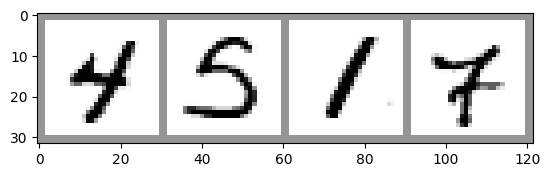

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [37]:
#model = VisionTransformer(image_size=28, patch_size=4, num_layers=8, num_heads=2, hidden_dim=1024, mlp_dim=2048, num_classes=10)
model = VisionTransformer(image_size=28, patch_size=4, num_layers=4, num_heads=2, hidden_dim=20, mlp_dim=20, num_classes=10)

In [38]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.7148, 0.3810, 0.2885, 0.2747, 0.1569, 0.6267, 0.4634, 0.1774, 0.1731,
         0.9367],
        [0.8505, 0.1673, 0.8981, 0.0664, 0.7748, 0.2739, 0.5148, 0.2515, 0.0698,
         0.4446],
        [0.2813, 0.2171, 0.2306, 0.9282, 0.2284, 0.1044, 0.6587, 0.5225, 0.9154,
         0.3617],
        [0.8090, 0.6413, 0.1778, 0.4996, 0.2562, 0.5152, 0.2518, 0.0927, 0.3004,
         0.1804]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.3373970985412598


In [39]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [40]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            #add wandb
            #tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [43]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 1

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # # Log the running loss averaged per batch
    # # for both training and validation
    # writer.add_scalars('Training vs. Validation Loss',
    #                 { 'Training' : avg_loss, 'Validation' : avg_vloss },
    #                 epoch_number + 1)
    # writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 0.24061456316709517
  batch 2000 loss: 0.23935570878942963
  batch 3000 loss: 0.23877518576988951
  batch 4000 loss: 0.2076254798754817
  batch 5000 loss: 0.22575222880241927
  batch 6000 loss: 0.22473706825834233
  batch 7000 loss: 0.21811500158917624
  batch 8000 loss: 0.21109402618685272
  batch 9000 loss: 0.2073360264034709
  batch 10000 loss: 0.22401232050324324
  batch 11000 loss: 0.21522854207549244
  batch 12000 loss: 0.19607390951702836
  batch 13000 loss: 0.19298151028132998
  batch 14000 loss: 0.19622572708997177
  batch 15000 loss: 0.19879801859799773
LOSS train 0.19879801859799773 valid 0.17331372201442719


In [54]:
model.eval()
with torch.no_grad():
    total = 0
    num_correct = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        print(voutputs.shape)
        pred = torch.argmax(voutputs, dim=1)
        num_not_equal = torch.sum(tensor1 != tensor2)
        print(pred)
        print(vlabels)
        

torch.Size([4, 10])
tensor([7, 2, 1, 0])
tensor([7, 2, 1, 0])
torch.Size([4, 10])
tensor([4, 1, 4, 9])
tensor([4, 1, 4, 9])
torch.Size([4, 10])
tensor([5, 9, 0, 6])
tensor([5, 9, 0, 6])
torch.Size([4, 10])
tensor([9, 0, 1, 5])
tensor([9, 0, 1, 5])
torch.Size([4, 10])
tensor([9, 7, 3, 4])
tensor([9, 7, 3, 4])
torch.Size([4, 10])
tensor([9, 6, 6, 5])
tensor([9, 6, 6, 5])
torch.Size([4, 10])
tensor([4, 0, 7, 4])
tensor([4, 0, 7, 4])
torch.Size([4, 10])
tensor([0, 1, 3, 3])
tensor([0, 1, 3, 1])
torch.Size([4, 10])
tensor([3, 6, 7, 2])
tensor([3, 4, 7, 2])
torch.Size([4, 10])
tensor([7, 1, 2, 1])
tensor([7, 1, 2, 1])
torch.Size([4, 10])
tensor([1, 7, 4, 2])
tensor([1, 7, 4, 2])
torch.Size([4, 10])
tensor([3, 5, 1, 2])
tensor([3, 5, 1, 2])
torch.Size([4, 10])
tensor([4, 4, 6, 3])
tensor([4, 4, 6, 3])
torch.Size([4, 10])
tensor([5, 5, 6, 0])
tensor([5, 5, 6, 0])
torch.Size([4, 10])
tensor([4, 1, 9, 5])
tensor([4, 1, 9, 5])
torch.Size([4, 10])
tensor([7, 8, 9, 3])
tensor([7, 8, 9, 3])
torch.Si

KeyboardInterrupt: 